In [ ]:
from collections import abc

import numpy as np
import scipy
from matplotlib import pyplot as plt

ndarray = np.ndarray

In [ ]:
FFT_NORM = "forward"


def get_block(k: int, omega: float, M: ndarray, C: ndarray, K: ndarray):
    return -k * omega**2 * M + 1j * k * omega * C + K


def get_A(NH: int, omega: float, M: ndarray, C: ndarray, K: ndarray):
    return scipy.sparse.block_diag(
        [get_block(k, omega, M, C, K) for k in range(0, NH + 1)]
    ).tocsr()


def get_b_ext(
    NH: int,
    N: int,
    ks: abc.Iterable[int],
    dofs: abc.Iterable[int],
    is_cosines: abc.Iterable[bool],
    coefficients: abc.Iterable[float],
):
    """Return the exponential Fourier coefficients of the external force given
    cosine and sine coefficients.

    If an index is specified more than once (e.g., for both a cosine and sine
    coefficient), all corresponding coefficients are applied via addition.

    Parameters
    ----------
    NH
        The number of assumed harmonics, i.e., 0, 1, ..., N_H
    N
        The number of degrees of freedom in the system
    ks
        The harmonic indices corresponding to each coefficient in `coefficients`
    dofs
        The degree of freedom indices corresponding to each coefficient in
        `coefficients`
    is_cosines
        Whether each corresponding coefficient in `coefficients` is cosine
    coefficients
        The coefficients of cosine and/or sine in the external force
    """
    length = len(ks)
    if (
        length != len(dofs)
        or length != len(is_cosines)
        or length != len(coefficients)
    ):
        raise ValueError(
            "`ks`, `dofs`, `is_cosines`, `coefficients` do not all have the"
            " same length"
        )

    if any(k > NH for k in ks):
        raise ValueError(
            "At least one specified harmonic index is greater than NH."
        )
    if any(dof >= N for dof in dofs):
        raise ValueError(
            "At least one specified degree of freedom is greater than or equal"
            " to N."
        )

    if not isinstance(ks, ndarray):
        ks = np.array(ks, dtype=int)
    if not isinstance(dofs, ndarray):
        dofs = np.array(dofs, dtype=int)
    if not isinstance(is_cosines, ndarray):
        is_cosines = np.array(is_cosines, dtype=bool)

    k_neq_0_mask = ks != 0
    exp_coefficients = np.array(coefficients, dtype=complex)
    exp_coefficients[k_neq_0_mask & ~is_cosines] *= -1j
    exp_coefficients[k_neq_0_mask] /= 2

    total_length = N * (NH + 1)
    indices = N * ks + dofs

    return scipy.sparse.csc_array(
        (exp_coefficients, (indices, np.zeros(length))),
        shape=(total_length, 1),
        dtype=complex,
    )


def extract_dofs(coefficients: ndarray, NH: int, N: int):
    """Reshape the coefficients by degree of freedom.

    Parameters
    ----------
    coefficients
        Should be of the form (a0, a1, ..., aNH) where ak denotes the
        coefficients of the 0th harmonic for all N degrees of freedom.

    Returns
    -------
    reshaped
        Coefficients where each row corresponds to a degree of freedom
        shape (N, NH + 1)
    """
    return np.reshape(coefficients, (N, NH + 1), order="F")

In [ ]:
NH = 30
N = 2
m1, m2 = 1, 2
c1, c2, c3 = 1, 0.5, 2
k1, k2, k3 = 1, 0.5, 2

M = np.diag([m1, m2])
C = np.array([[c1 + c2, -c2], [-c2, c2 + c3]])
K = np.array([[k1 + k2, -k2], [-k2, k2 + k3]])

omega = 2
t0, tf = tlim = 0, 2 * np.pi / omega
tn = NH * 2
tls = np.linspace(*tlim, tn)

In [ ]:
A = get_A(NH, omega, M, C, K)

b_ext = get_b_ext(NH, N, (1,), (0,), (1,), (2,))

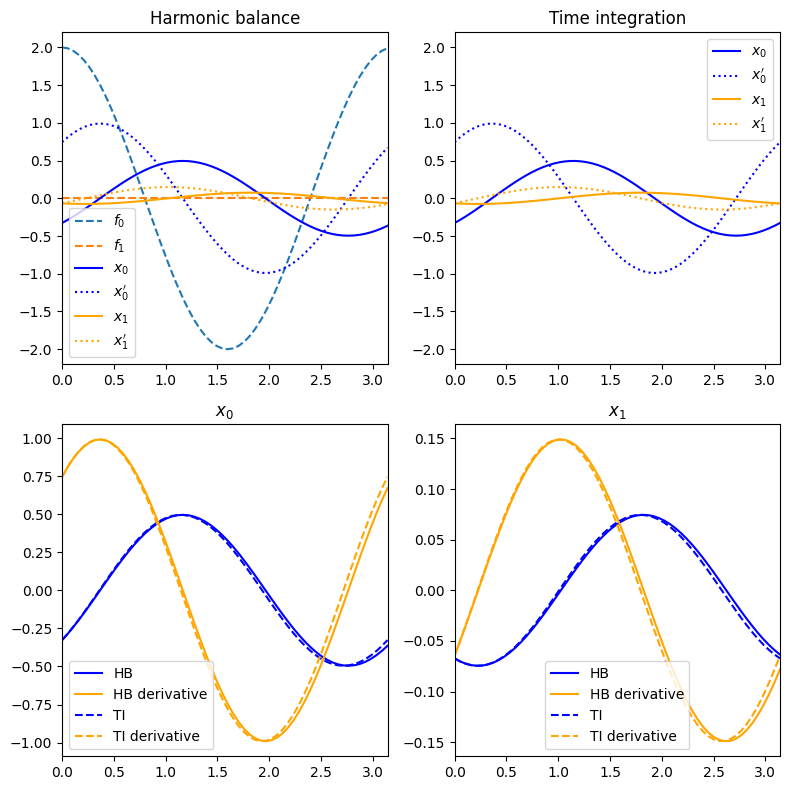

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
colors = ("blue", "orange")

ax = axs[0, 0]
ax.set_title("Harmonic balance")

bb_ext = extract_dofs(b_ext.toarray(), NH, N)
ff = scipy.fft.irfft(bb_ext, axis=1, norm=FFT_NORM)
names = [rf"f_{i}" for i in range(N)]
for f, color, name in zip(ff, colors, names):
    ax.plot(tls, f, label=f"${name}$", ls="--")

z = scipy.sparse.linalg.spsolve(A, b_ext)

zz = extract_dofs(z, NH, N)
xx = scipy.fft.irfft(zz, axis=1, norm=FFT_NORM)

derivative_factors = 1j * np.arange(NH + 1)
zzp = derivative_factors * zz * omega
xxp = scipy.fft.irfft(zzp, axis=1, norm=FFT_NORM)

names = [rf"x_{i}" for i in range(N)]
for x, xp, color, name in zip(xx, xxp, colors, names):
    ax.plot(tls, x, color=color, label=rf"${name}$")
    ax.plot(tls, xp, color=color, label=rf"${name}'$", ls=":")
ax.legend()


ax = axs[0, 1]
ax.set_title("Time integration")

x0 = xx[:, 0]
xp0 = xxp[:, 0]
y0 = np.concat((x0, xp0))


def ode(t, y, *args):
    omega, M, C, K = args

    x = y[:N]
    xp = y[N:]

    f = np.array([2 * np.cos(omega * t), 0])

    xpp = np.linalg.inv(M) @ (-C @ xp - K @ x + f)
    return np.concat((xp, xpp))


args = (omega, M, C, K)
sol = scipy.integrate.solve_ivp(ode, tlim, y0, t_eval=tls, args=args)

xx_ti = sol.y[:N]
xxp_ti = sol.y[N:]

for x, xp, color, name in zip(xx_ti, xxp_ti, colors, names):
    ax.plot(tls, x, color=color, label=rf"${name}$")
    ax.plot(tls, xp, color=color, label=rf"${name}'$", ls=":")
ax.legend()
ax.set_ylim(axs[0, 0].get_ylim())


for i in range(N):
    ax = axs[1, i]
    ax.set_title(rf"${names[i]}$")
    ax.plot(tls, xx[i], color=colors[0], label="HB")
    ax.plot(tls, xxp[i], color=colors[1], label="HB derivative")
    ax.plot(tls, xx_ti[i], color=colors[0], label="TI", ls="--")
    ax.plot(tls, xxp_ti[i], color=colors[1], label="TI derivative", ls="--")
    ax.legend()

[ax.set_xlim(*tlim) for ax in axs.ravel()]

fig.tight_layout()
plt.show()